# Demonstrating TCP Congestion Control
 
 ## Summary
 
Congestion happens in TCP when computers connected to a single link put more network packets onto the link than the link can support. Because TCP has a 100% transmission guarantee, if a sender detects lost packets, it will resend them. This will make the problem of congestion even worse.

In this Jupyter Notebook, I provide an easy way of writing and testing out different approaches to [congestion control](https://en.wikipedia.org/wiki/TCP_congestion_control), and provide an implementation of one of the original TCP congestion control approaches.

This uses [mahimahi](http://mahimahi.mit.edu/), a tool that allows network protocol developers to test different network conditions on a single machine. It comes with a bunch of options to spin up lightweight network containers that have links with different qualities. For instance, if you want to to test a link with a particular network delay, bandwidth, or queue size, you can do that quite easily.

The logic behind the setup here was inspired by work done in developing [indigo](https://github.com/StanfordSNR/indigo/tree/master/env), a reinforcement learning-based congestion control algorithm.
 
## Installation

All of the code for this project is at this [repo](https://github.com/squidarth/demonstrating-congestion-control). 
 
I've only tested this on Ubuntu--if you are using MacOS or another operating system, I highly suggest using [Vagrant](https://www.vagrantup.com) to spin up a VM.
 
 ```bash
$ sudo apt-get update
$ sudo apt-get install mahimahi python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install -r requirements.txt

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
 ```
 
 ## Usage
 
Scroll down to the bottom of the notebook to see full examples, but here's a quick start:

```python

mahimahi_settings = {
    'delay': 100,
    'queue_size': 1,
    'trace_file': TRACE_FILES['114.68MBPS']
}

run_with_mahi_settings(mahimahi_settings, 10, [Sender(port, TahoeStrategy(10, 1))])
```

The `run_with_mahi_settings` function takes some settings, notably a `delay`, `queue_size`, and `trace_file`, along with a number of seconds that it should run for and a congestion control strategy, and then prints out some statistics on what happened. What this does is create a single sender/receiver pair that send UDP packets to one another over the mahimahi boundary.

This UDP connection, while not actually TCP, is a decent way of simulating how TCP would perform over those
network conditions, with the selected strategy.

### Writing a congestion control strategy

All congestion control strategies must inherit from `SenderStrategy`, and implement the methods `next_packet_to_send` and `process_ack`. See the `FixedWindowStrategy` in `src/strategies.py` for the simplest example of this. The `TahoeStrategy` later on in this notebook might be a better guide.

 
 ## More Details
 
 ### Trace Files
 
 The trace files were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env)
 
 This repository comes with a number of trace files in the `traces/` folder. These were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env). Each of these is a list of timestamps
 at which the link can send a 1500 byte packet, and it is used to set the bandwidth of the network. For a 12mbps
 (1500 bytes), it would contain numbers matching:
 
 ```
 1
 2
 3
 4
 ...
 ```

In [1]:
import socket
import select
import json
import time
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
from src.helpers import run_with_mahi_settings, get_open_udp_port
from src.senders import Sender
from src.strategies import SenderStrategy, FixedWindowStrategy


In [2]:
TRACE_FILES = {
    '0.57MBPS': '0.57mbps-poisson.trace',
    '2.64MBPS': '2.64mbps-poisson.trace',
    '3.04MBPS': '3.04mbps-poisson.trace',
    '100.42MBPS': '100.42mbps.trace',
    '114.68MBPS': '114.68mbps.trace'
}

## With No Congestion Control

The `FixedWindowStrategy` does not do any congestion control, and very simply sends a fixed number of packets on every round trip. The way this works is that the sender will send packets out until it has sent some number N out. It cannot send out any more until acknowledgements start coming back.

This fixed number of packets is called the "window", and we'll revisit it in later iterations of congestion control.

The larger the window, the higher the rate of packet sending.

[sender] Connected to receiver: 100.64.0.4:35240

Results for sender 46696:
Total Acks: 7030
Num Duplicate Acks: 6427
% duplicate acks: 91.422475
Throughput (bytes/s): 4824.000000
Average RTT (ms): 756.741575


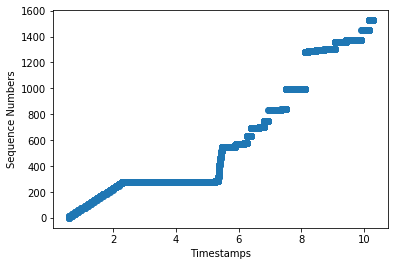

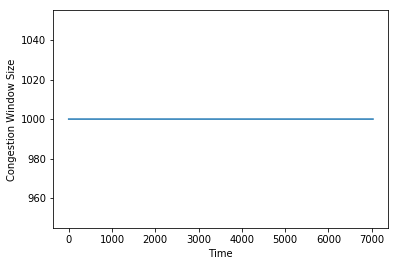

In [3]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 10, [Sender(port, FixedWindowStrategy(1000))])

# Congestion Control with Tahoe

TCP Tahoe is one of the first congestion control algorithms implemented. A rough sketch of its implementation is that it has two phases, slow start and congestion avoidance.

In the slow start phase, the congestion window (`cwnd`), that I discuss before, starts at 1, and increases by one on every acknowledgement the sender receives. Once the `cwnd` hits some configurable threshold, called the "Slow Start Threshold", the sender moves into "congestion avoidance", and the `cwnd` increases by 1 every time an *entire window* of packets is acknowledged. Effectively, this means that the `cwnd` grows quickly during the slow start, and more slowly during the congestion avoidance phase.

If a packet is lost, TCP Tahoe performs a protocol called "Fast Retransmit". In "Fast Retransmit", the lost packet is retransmitted, the `cwnd` is set to 1, and the slow start threshold is updated to half of the current `cwnd`.

My implementation, and some of the results, are below.

In [4]:
class TahoeStrategy(SenderStrategy):
    def __init__(self, slow_start_thresh: int, initial_cwnd: int) -> None:
        self.slow_start_thresh = slow_start_thresh

        self.cwnd = initial_cwnd
        self.fast_retransmit_packet = None
        self.time_since_retransmit = None
        self.retransmitting_packet = False
        self.ack_count = 0

        self.duplicated_ack = None
        self.slow_start_thresholds = []

        super().__init__()

    def window_is_open(self) -> bool:
        # next_ack is the sequence number of the next acknowledgement
        # we are expecting to receive. If the gap between next_ack and
        # seq_num is greater than the window, then we need to wait for
        # more acknowledgements to come in.
        return self.seq_num - self.next_ack < self.cwnd

    def next_packet_to_send(self) -> Optional[str]:
        send_data = None
        if self.retransmitting_packet and self.time_of_retransmit and time.time() - self.time_of_retransmit > 1:
            # The retransmit packet timed out--resend it
            self.retransmitting_packet = False

        if self.fast_retransmit_packet and not self.retransmitting_packet:
            # Logic for resending the packet
            self.unacknowledged_packets[self.fast_retransmit_packet['seq_num']]['send_ts'] = time.time()
            send_data = self.fast_retransmit_packet
            serialized_data = json.dumps(send_data)
            self.retransmitting_packet = True

            self.time_of_retransmit = time.time()

        elif self.window_is_open():
            send_data = {
                'seq_num': self.seq_num,
                'send_ts': time.time()
            }

            self.unacknowledged_packets[self.seq_num] = send_data
            self.seq_num += 1
        else:
            # Check to see if any segments have timed out. Note that this
            # isn't how TCP actually works--traditional TCP uses exponential
            # backoff for computing the timeouts
            for seq_num, segment in self.unacknowledged_packets.items():
                if time.time() - segment['send_ts'] > 4:
                    self.unacknowledged_packets[seq_num]['send_ts'] = time.time()
                    return json.dumps(segment)

        if send_data is None:
            return None
        else:
            return json.dumps(send_data)


    def process_ack(self, serialized_ack: str) -> None:
        ack = json.loads(serialized_ack)
        if ack.get('handshake'):
            return

        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))


        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            if self.duplicated_ack and ack['seq_num'] == self.duplicated_ack['seq_num']:
                self.curr_duplicate_acks += 1
            else:
                self.duplicated_ack = ack
                self.curr_duplicate_acks = 1

            if self.curr_duplicate_acks == 3:
                # Received 3 duplicate acks, retransmit
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
                self.slow_start_thresh = int(max(1, self.cwnd/2))
                self.cwnd = 1
        elif ack['seq_num'] >= self.next_ack:
            if self.fast_retransmit_packet:
                self.fast_retransmit_packet = None
                self.retransmitting_packet = False
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1

            # Acknowledge all packets where seq_num < ack['seq_num']
            self.unacknowledged_packets = {
                k:v
                for k,v in
                self.unacknowledged_packets.items()
                if k > ack['seq_num']
            }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.ack_count += 1
            self.sent_bytes = ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            if self.cwnd < self.slow_start_thresh:
                # In slow start
                self.cwnd += 1
            elif (ack['seq_num'] + 1) % self.cwnd == 0:
                # In congestion avoidance
                self.cwnd += 1

        self.cwnds.append(self.cwnd)
        self.slow_start_thresholds.append(self.slow_start_thresh)

## Understanding the inputs

The three parameters to the link are `delay`, `queue_size`, and `trace_file`. As I mention at the beginning of this doc, the `trace_file` corresponds to the bandwidth. The way I've set this up, I've set the queue size to be the bandwidth-delay product (BDP) of the link, which is the number of bytes that the link can accomodate at any given point in time.

### Bandwidth-delay product

The BDP is computed as the product of the delay and bandwidth of a link. You can think of the bandwidth as the "width" of the link--how much information can flow through it in a given second, and the delay as the "length"--how long does it take for one packet to make it to the other end of the wire. The BDP can then be thought of as the "volume" of the link. A link is used optimally when a sender keeps the BDP number of bytes in flight at any given point in time. 

## Understanding the output

The main things to note here from the output are the throughput (bytes/s) and average RTT (ms). The output for each of these experiments also includes graphs. All senders include a graph of the timestamps at which each sequence number is received, as well as a graph of the congestion window over time. The Tahoe senders also include a graph of the slow start threshold (read on to find out more about what this means).

Notice that the Tahoe graphs of the congestion windows have sawtooth behavior, where they increase for a while before dropping back down to 0. The behavior of dropping back down to 0 is the result of packet loss.

## Low Bandwidth

In this setting, the delay is set to 88ms, the bandwidth is set to be 2.64MBPS, and the queue size is the BDP of the link, 26.4KB. 

Notice the saw-tooth behavior in the graph of the congestion window, and that the window drops fairly consistently at a window size of ~600.

Each byte in this experiment is 80 bytes, so this means that drops start occuring when the sender attempts to keep 48000 bytes in flight at any point in time. Note that the link can accomodate 26400 bytes, and that the link has a queue of 26400 bytes, so this number is roughly equivalent to that sum.

[sender] Connected to receiver: 100.64.0.6:46887

Results for sender 36279:
Total Acks: 348269
Num Duplicate Acks: 5005
% duplicate acks: 1.437108
Throughput (bytes/s): 114346.000000
Average RTT (ms): 220.506767


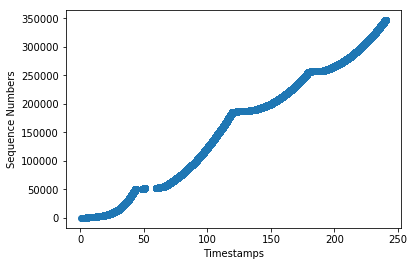

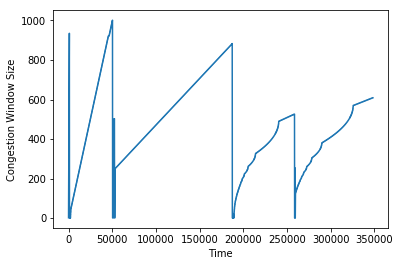

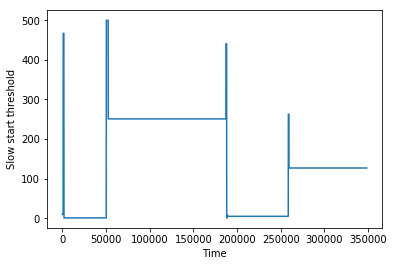

In [5]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}


port = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 240, [Sender(port, TahoeStrategy(10, 1))])

## High Bandwidth

Similarly to the low bandwidth setup, queue size is set to be equal to the BDP of the link. Unlike the low bandwidth setup, we see the the high bandwidth setup gets to much higher congestion window sizes. However, it's still nowhere near the BDP of this link.

What this demonstrates that even if a link is capable of sending more packets than another, it doesn't necessarily mean that it can be used in its entirety. In this particular example, the bottleneck is the receiver, and the congestion control algorithm is still able to adapt to what the receiver can handle.

[sender] Connected to receiver: 100.64.0.2:39378

Results for sender 37783:
Total Acks: 649011
Num Duplicate Acks: 4017
% duplicate acks: 0.618942
Throughput (bytes/s): 214706.666667
Average RTT (ms): 183.205910


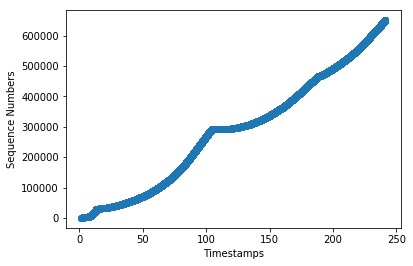

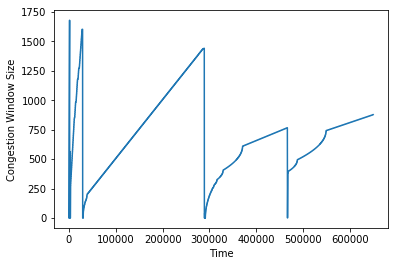

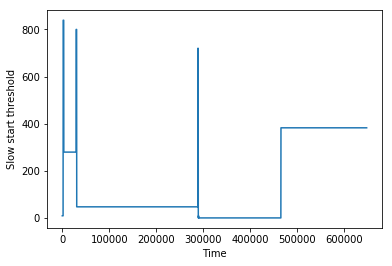

In [4]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 1104620,
    'trace_file': TRACE_FILES['100.42MBPS']
}

port = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 240, [Sender(port, TahoeStrategy(10, 1))])

## Low Bandwidth, 2 Fixed Window Senders

Notice that when we put two fixed window senders (no congestion control) in contention with each other, the throughput completely collapses. While with a single fixed window sender, the throughput is around 77kb, here it drops to ~400b for each sender.

This is because since the senders don't drop the number of packets that they send in response to drops, they continue to overload the link and cause more drops.

[sender] Connected to receiver: 100.64.0.12:36280

[sender] Connected to receiver: 100.64.0.12:36280

Results for sender 59055:
Total Acks: 10345
Num Duplicate Acks: 10049
% duplicate acks: 97.138714
Throughput (bytes/s): 394.666667
Average RTT (ms): 1963.733075


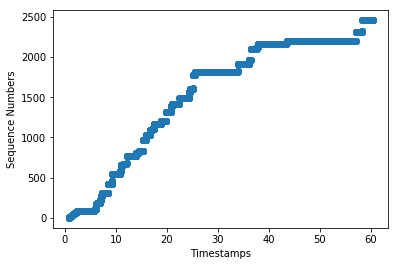

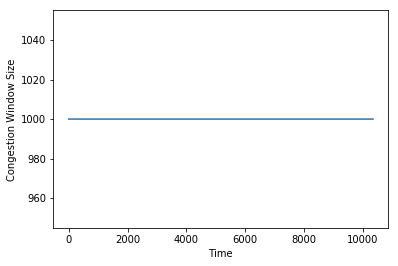



Results for sender 56771:
Total Acks: 3341
Num Duplicate Acks: 3037
% duplicate acks: 90.900928
Throughput (bytes/s): 405.333333
Average RTT (ms): 1360.758694


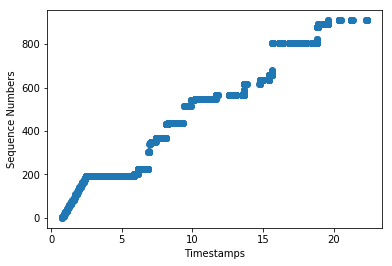

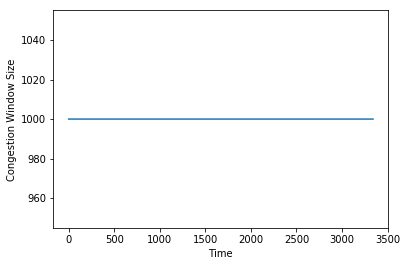

In [9]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = get_open_udp_port()
port2 = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 60, [Sender(port, FixedWindowStrategy(1000)), Sender(port2, FixedWindowStrategy(1000))])

## Low Bandwidth, 1 Fixed Window, 1 Tahoe

In this scenario, we put a fixed window sender in contention with a tahoe sender. Notice here that the fixed window sender hogs the entire link, and starved out the Tahoe sender's packets. The average RTT of the Tahoe sender is 1730 because its packets are getting stuck in the queue, and it ended up only getting 7 packets through in an entire minute.

[sender] Connected to receiver: 100.64.0.6:46944

[sender] Connected to receiver: 100.64.0.6:46944

Results for sender 57126:
Total Acks: 7
Num Duplicate Acks: 2
% duplicate acks: 28.571429
Throughput (bytes/s): 6.666667
Average RTT (ms): 1730.737257


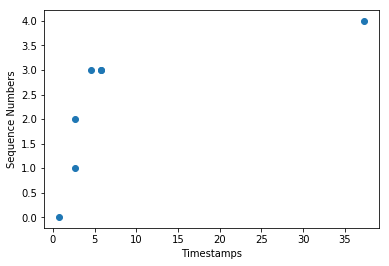

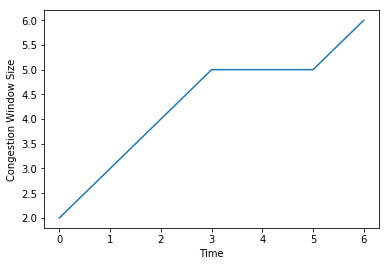

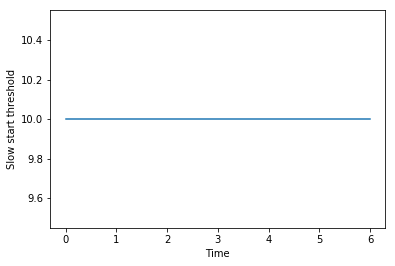


Results for sender 36758:
Total Acks: 10891
Num Duplicate Acks: 10292
% duplicate acks: 94.500046
Throughput (bytes/s): 798.666667
Average RTT (ms): 1500.501963


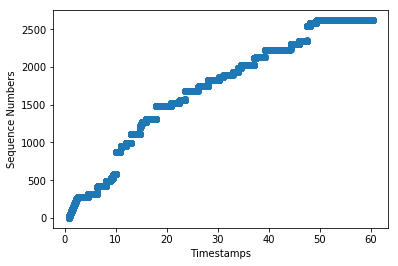

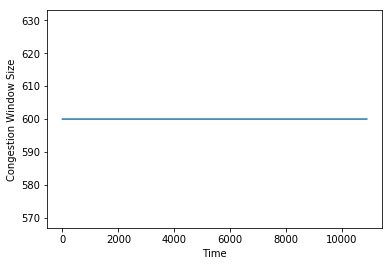

In [16]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = get_open_udp_port()
port2 = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 60, [Sender(port, TahoeStrategy(10, 1)), Sender(port2, FixedWindowStrategy(600))])

## Low Bandwidth, 2 Tahoe Senders

In this case, we can see that the two Tahoe senders are fair to each other, and each achieves a throughput that is roughly half of what a single tahoe sender achieves on the same link.

[sender] Connected to receiver: 100.64.0.16:33207

[sender] Connected to receiver: 100.64.0.16:33207

Results for sender 45861:
Total Acks: 183693
Num Duplicate Acks: 2066
% duplicate acks: 1.124703
Throughput (bytes/s): 60415.666667
Average RTT (ms): 248.982606


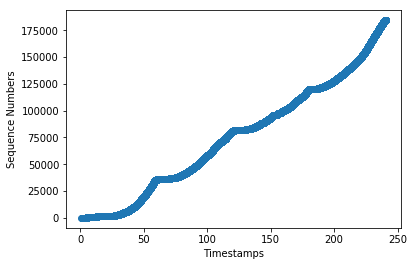

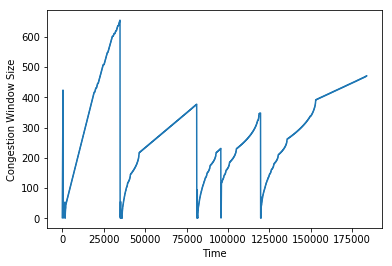

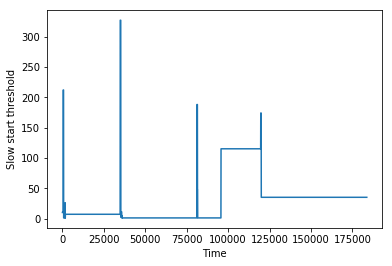


Results for sender 35767:
Total Acks: 198109
Num Duplicate Acks: 2406
% duplicate acks: 1.214483
Throughput (bytes/s): 64878.333333
Average RTT (ms): 242.212587


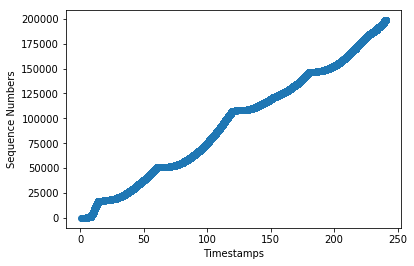

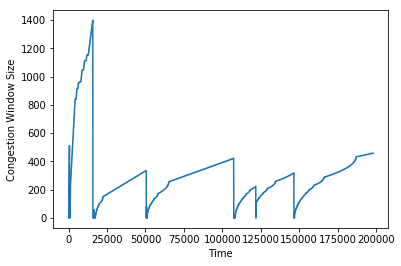

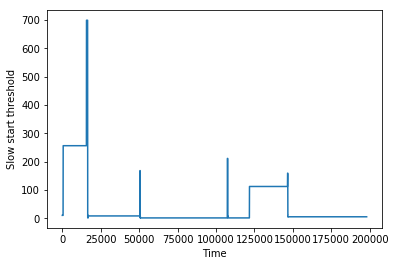

In [10]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = get_open_udp_port()
port2 = get_open_udp_port()
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, TahoeStrategy(10, 1)), Sender(port2, TahoeStrategy(10, 1))])